# LLM Context Relevance Judge Evaluation
We evalute 250 queries of the Hotpot QA dataset using GPT4o and Claude 3.5 Sonnet.
Prompt is:
```python
"""You are evaluating a search system.
You have to decide, if a retrieved paragraph is relevant to the user's question.

A relevant paragraph is a paragraph that helps to answers the question.

Use the following rating scheme:
1.0: covers full answer
0.5: contributes to the answer
0.0: not relevant

Think step by step. First try to answer the question. If you can, you have to rate 1.0. If not decide between 0.5 and 0.0.
Describe why you chose the rating. Do not repeat the rating scheme.
Finally, put out your rating of the relevance as number using the following notation without any markdown or text around it:

"Rating: "

Here is the paragraph:

{{ context }}

Here is the question: {{ question }}

"""
```

Beyond label agreement, we calculate Information Retrieval metrics:
- Hit Rate
- Mean Reciprocal Rank (MRR)
- Normalized Discounted Cumulative Gain (nDCG)
- Mean Average Precision (MAP)
We sample 50 result lists.

We found that using LLMs as alternative for human labels is a viable approach.
For binary labels we measured correlations above 0.9. When it comes to partially relevant snippets, LLMs do worse, still delivering a reasonable correlation 0f ~0.5.

In [1]:
import random
import math
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
def hit_rate(values):
    return max(values)

def mrr(values):
    for i, value in enumerate(values):
        if value:
            return 1/(i+1)
    return 0

def ndcg(values):
    dcg = sum([v / math.log(i + 2, 2) for i, v in enumerate(values)])
    idcg = sum([1 / math.log(i + 2, 2) for i in range(len(values))])
    return dcg / idcg

def mean_average_precision(values):
    average_precision = 0
    num_correct = 0
    for rank, value in enumerate(values, start=1):
        if value:
            num_correct += 1
            average_precision += num_correct / rank
    return average_precision / max(num_correct, 1)

## GPT-4o

In [3]:
import pandas as pd

df_gpt4o = pd.read_csv("../../data/context_relevance/llm_judge_hotpot_qa_distractor_validation_gpt4o.csv")
sampled_context_relevance_ds = df_gpt4o.to_dict(orient="records")

all_sampled_ids = set(entry["id"] for entry in sampled_context_relevance_ds)
len(all_sampled_ids)

250

### raw labels

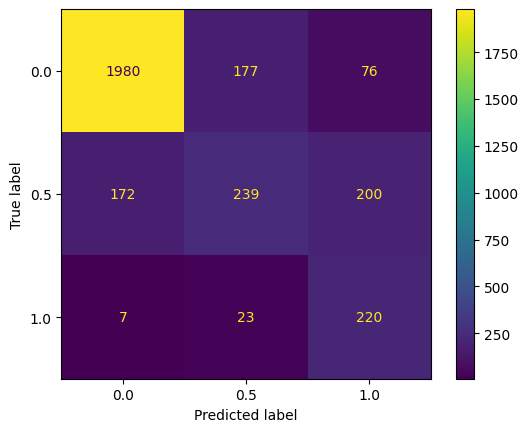

In [4]:
gold_labels = [entry["relevance_value"] for entry in sampled_context_relevance_ds]
llm_judge_labels = [entry["llm_judge_rating"] for entry in sampled_context_relevance_ds]

def to_category(value):
    return str(value)

cm = confusion_matrix(list(map(to_category, gold_labels)), list(map(to_category, llm_judge_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0.0", "0.5", "1.0"])
disp.plot()

### all labels

In [5]:
gold_hit_rates = []
gold_mrrs = []
gold_ndcgs = []
gold_maps = []

llm_judge_hit_rates = []
llm_judge_mrrs = []
llm_judge_ndcgs = []
llm_judge_maps = []

binary_llm_judge_hit_rates = []
binary_llm_judge_mrrs = []
binary_llm_judge_ndcgs = []
binary_llm_judge_maps = []

k = 50
top_k = 5
random.seed(42)

# only fully_relevant and not_relevant
label_types = ["gold_context_full", "gold_context_part", "distractor_context_part"]
for _ in range(k):
    gold_hit_rate_per_query = []
    gold_mrr_per_query = []
    gold_ndcg_per_query = []
    gold_maps_per_query = []

    llm_judge_hit_rate_per_query = []
    llm_judge_mrr_per_query = []
    llm_judge_ndcg_per_query = []
    llm_judge_map_per_query = []

    binary_llm_judge_hit_rate_per_query = []
    binary_llm_judge_mrr_per_query = []
    binary_llm_judge_ndcg_per_query = []
    binary_llm_judge_map_per_query = []

    for id in all_sampled_ids:
        id_sample = [entry for entry in sampled_context_relevance_ds if entry["id"] == id and entry["type"] in label_types]
        random.shuffle(id_sample)
        simulated_hit_list = id_sample[:top_k]

        gold_values = [entry["relevance_value"] for entry in simulated_hit_list]
        llm_judge_ratings = [entry["llm_judge_rating"] for entry in simulated_hit_list]
        binary_judge_ratings = [1 if rating > 0.5 else 0 for rating in llm_judge_ratings]

        gold_hit_rate = hit_rate(gold_values)
        llm_judge_hit_rate = hit_rate(llm_judge_ratings)
        binary_llm_judge_hit_rate = hit_rate(binary_judge_ratings)
        gold_mrr = mrr(gold_values)
        llm_judge_mrr = mrr(llm_judge_ratings)
        binary_llm_judge_mrr = mrr(binary_judge_ratings)
        gold_ndcg = ndcg(gold_values)
        llm_judge_ndcg = ndcg(llm_judge_ratings)
        binary_llm_judge_ndcg = ndcg(binary_judge_ratings)
        gold_map_score = mean_average_precision(gold_values)
        llm_judge_map_score = mean_average_precision(llm_judge_ratings)
        binary_llm_judge_map_score = mean_average_precision(binary_judge_ratings)

        gold_hit_rate_per_query.append(gold_hit_rate)
        llm_judge_hit_rate_per_query.append(llm_judge_hit_rate)
        binary_llm_judge_hit_rate_per_query.append(binary_llm_judge_hit_rate)
        gold_mrr_per_query.append(gold_mrr)
        llm_judge_mrr_per_query.append(llm_judge_mrr)
        binary_llm_judge_mrr_per_query.append(binary_llm_judge_mrr)
        gold_ndcg_per_query.append(gold_ndcg)
        llm_judge_ndcg_per_query.append(llm_judge_ndcg)
        binary_llm_judge_ndcg_per_query.append(binary_llm_judge_ndcg)
        gold_maps_per_query.append(gold_map_score)
        llm_judge_map_per_query.append(llm_judge_map_score)
        binary_llm_judge_map_per_query.append(binary_llm_judge_map_score)

    gold_hit_rates.append(np.mean(gold_hit_rate_per_query))
    gold_mrrs.append(np.mean(gold_mrr_per_query))
    gold_ndcgs.append(np.mean(gold_ndcg_per_query))
    gold_maps.append(np.mean(gold_maps_per_query))
    llm_judge_hit_rates.append(np.mean(llm_judge_hit_rate_per_query))
    llm_judge_mrrs.append(np.mean(llm_judge_mrr_per_query))
    llm_judge_ndcgs.append(np.mean(llm_judge_ndcg_per_query))
    llm_judge_maps.append(np.mean(llm_judge_map_per_query))
    binary_llm_judge_hit_rates.append(np.mean(binary_llm_judge_hit_rate_per_query))
    binary_llm_judge_mrrs.append(np.mean(binary_llm_judge_mrr_per_query))
    binary_llm_judge_ndcgs.append(np.mean(binary_llm_judge_ndcg_per_query))
    binary_llm_judge_maps.append(np.mean(binary_llm_judge_map_per_query))


In [6]:
pd.DataFrame([
    { "metric": "hit_rate", "gold": np.mean(gold_hit_rates), "llm_judge": np.mean(llm_judge_hit_rates), "correlation": pearsonr(gold_hit_rates, llm_judge_hit_rates).statistic },
    { "metric": "mrr", "gold": np.mean(gold_mrrs), "llm_judge": np.mean(llm_judge_mrrs), "correlation": pearsonr(gold_mrrs, llm_judge_mrrs).statistic },
    { "metric": "ndcg", "gold": np.mean(gold_ndcgs), "llm_judge": np.mean(llm_judge_ndcgs), "correlation": pearsonr(gold_ndcgs, llm_judge_ndcgs).statistic },
    { "metric": "map", "gold": np.mean(gold_maps), "llm_judge": np.mean(llm_judge_maps), "correlation": pearsonr(gold_maps, llm_judge_maps).statistic},
    ])

,metric,gold,llm_judge,correlation
0,hit_rate,0.670640,0.724920,0.802500
1,mrr,0.518400,0.500195,0.636923
2,ndcg,0.194688,0.234557,0.705295
3,map,0.494498,0.478850,0.596627


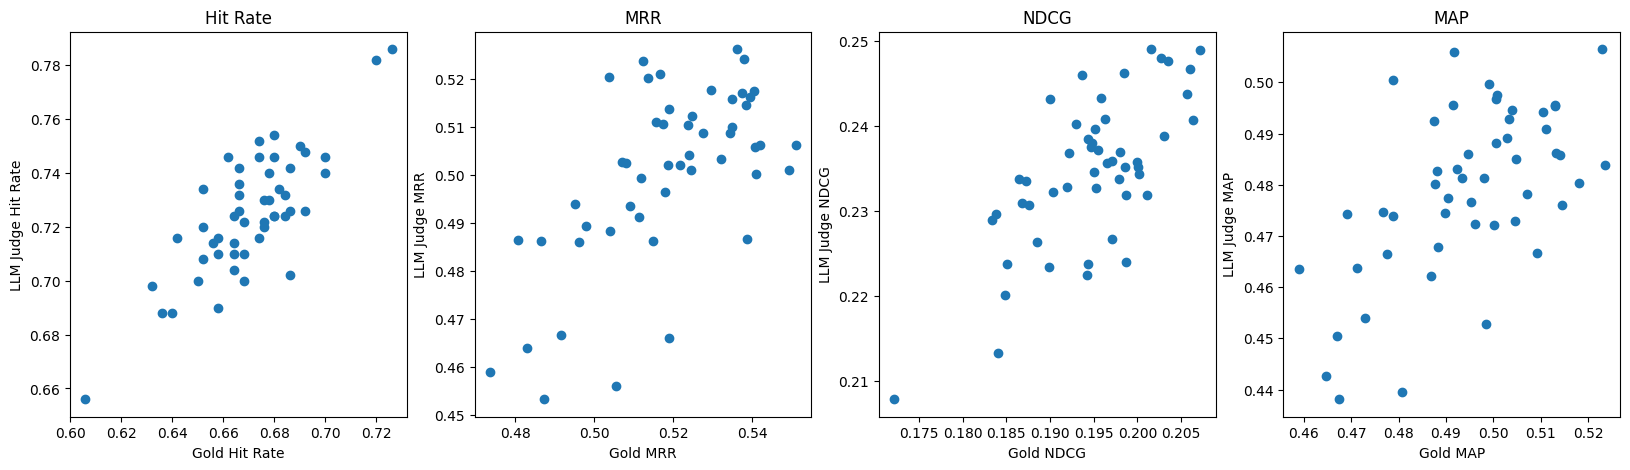

In [7]:

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.scatter(gold_hit_rates, llm_judge_hit_rates)
plt.xlabel("Gold Hit Rate")
plt.ylabel("LLM Judge Hit Rate")
plt.title("Hit Rate")
plt.subplot(1, 4, 2)
plt.scatter(gold_mrrs, llm_judge_mrrs)
plt.xlabel("Gold MRR")
plt.ylabel("LLM Judge MRR")
plt.title("MRR")
plt.subplot(1, 4, 3)
plt.scatter(gold_ndcgs, llm_judge_ndcgs)
plt.xlabel("Gold NDCG")
plt.ylabel("LLM Judge NDCG")
plt.title("NDCG")
plt.subplot(1, 4, 4)
plt.scatter(gold_maps, llm_judge_maps)
plt.xlabel("Gold MAP")
plt.ylabel("LLM Judge MAP")
plt.title("MAP")
plt.show()

In [8]:
print("Binary judge (>0.5)")
pd.DataFrame([
    { "metric": "hit_rate", "gold": np.mean(gold_hit_rates), "llm_judge": np.mean(binary_llm_judge_hit_rates), "correlation": pearsonr(gold_hit_rates, binary_llm_judge_hit_rates).statistic },
    { "metric": "mrr", "gold": np.mean(gold_mrrs), "llm_judge": np.mean(binary_llm_judge_mrrs), "correlation": pearsonr(gold_mrrs, binary_llm_judge_mrrs).statistic },
    { "metric": "ndcg", "gold": np.mean(gold_ndcgs), "llm_judge": np.mean(binary_llm_judge_ndcgs), "correlation": pearsonr(gold_ndcgs, binary_llm_judge_ndcgs).statistic },
    { "metric": "map", "gold": np.mean(gold_maps), "llm_judge": np.mean(binary_llm_judge_maps), "correlation": pearsonr(gold_maps, binary_llm_judge_maps).statistic},
    ])

Binary judge (>0.5)


,metric,gold,llm_judge,correlation
0,hit_rate,0.670640,0.606560,0.729821
1,mrr,0.518400,0.313915,0.467068
2,ndcg,0.194688,0.164002,0.647932
3,map,0.494498,0.306040,0.456347


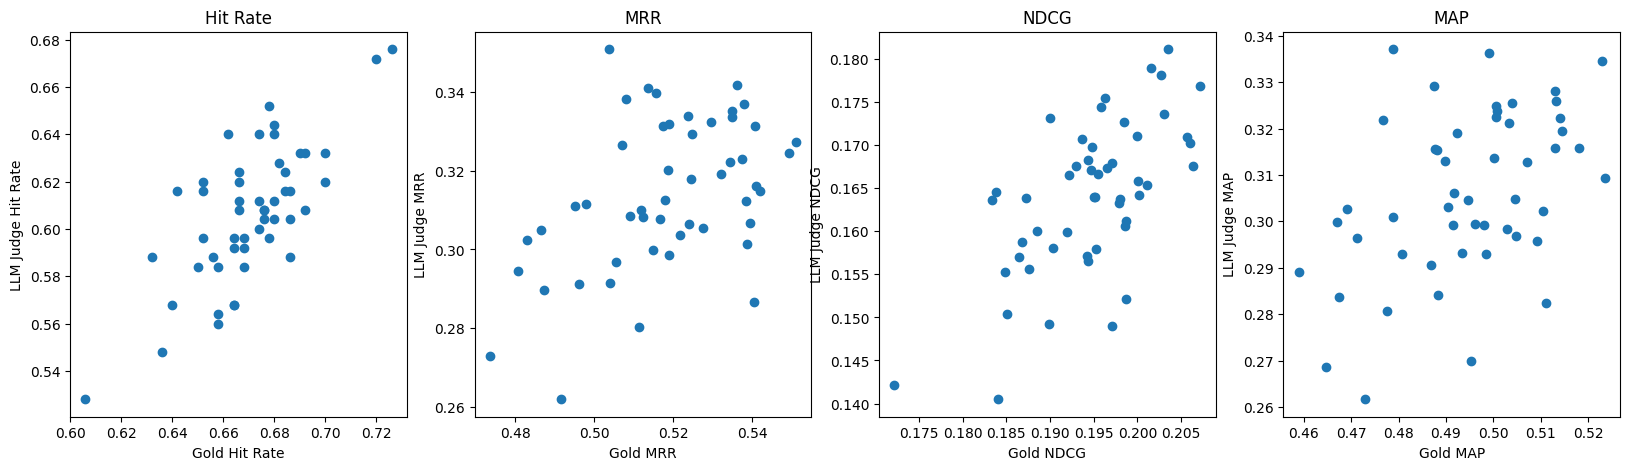

In [9]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.scatter(gold_hit_rates, binary_llm_judge_hit_rates)
plt.xlabel("Gold Hit Rate")
plt.ylabel("LLM Judge Hit Rate")
plt.title("Hit Rate")
plt.subplot(1, 4, 2)
plt.scatter(gold_mrrs, binary_llm_judge_mrrs)
plt.xlabel("Gold MRR")
plt.ylabel("LLM Judge MRR")
plt.title("MRR")
plt.subplot(1, 4, 3)
plt.scatter(gold_ndcgs, binary_llm_judge_ndcgs)
plt.xlabel("Gold NDCG")
plt.ylabel("LLM Judge NDCG")
plt.title("NDCG")
plt.subplot(1, 4, 4)
plt.scatter(gold_maps, binary_llm_judge_maps)
plt.xlabel("Gold MAP")
plt.ylabel("LLM Judge MAP")
plt.title("MAP")
plt.show()

### full vs not_relevant

In [10]:
gold_hit_rates = []
gold_mrrs = []
gold_ndcgs = []
gold_maps = []

llm_judge_hit_rates = []
llm_judge_mrrs = []
llm_judge_ndcgs = []
llm_judge_maps = []

binary_llm_judge_hit_rates = []
binary_llm_judge_mrrs = []
binary_llm_judge_ndcgs = []
binary_llm_judge_maps = []

k = 50
top_k = 5
random.seed(42)

# only fully_relevant and not_relevant
label_types = ["gold_context_full", "distractor_context_part"]
for _ in range(k):
    gold_hit_rate_per_query = []
    gold_mrr_per_query = []
    gold_ndcg_per_query = []
    gold_maps_per_query = []

    llm_judge_hit_rate_per_query = []
    llm_judge_mrr_per_query = []
    llm_judge_ndcg_per_query = []
    llm_judge_map_per_query = []

    binary_llm_judge_hit_rate_per_query = []
    binary_llm_judge_mrr_per_query = []
    binary_llm_judge_ndcg_per_query = []
    binary_llm_judge_map_per_query = []

    for id in all_sampled_ids:
        id_sample = [entry for entry in sampled_context_relevance_ds if entry["id"] == id and entry["type"] in label_types]
        random.shuffle(id_sample)
        simulated_hit_list = id_sample[:top_k]

        gold_values = [entry["relevance_value"] for entry in simulated_hit_list]
        llm_judge_ratings = [entry["llm_judge_rating"] for entry in simulated_hit_list]
        binary_judge_ratings = [1 if rating > 0.5 else 0 for rating in llm_judge_ratings]

        gold_hit_rate = hit_rate(gold_values)
        llm_judge_hit_rate = hit_rate(llm_judge_ratings)
        binary_llm_judge_hit_rate = hit_rate(binary_judge_ratings)
        gold_mrr = mrr(gold_values)
        llm_judge_mrr = mrr(llm_judge_ratings)
        binary_llm_judge_mrr = mrr(binary_judge_ratings)
        gold_ndcg = ndcg(gold_values)
        llm_judge_ndcg = ndcg(llm_judge_ratings)
        binary_llm_judge_ndcg = ndcg(binary_judge_ratings)
        gold_map_score = mean_average_precision(gold_values)
        llm_judge_map_score = mean_average_precision(llm_judge_ratings)
        binary_llm_judge_map_score = mean_average_precision(binary_judge_ratings)

        gold_hit_rate_per_query.append(gold_hit_rate)
        llm_judge_hit_rate_per_query.append(llm_judge_hit_rate)
        binary_llm_judge_hit_rate_per_query.append(binary_llm_judge_hit_rate)
        gold_mrr_per_query.append(gold_mrr)
        llm_judge_mrr_per_query.append(llm_judge_mrr)
        binary_llm_judge_mrr_per_query.append(binary_llm_judge_mrr)
        gold_ndcg_per_query.append(gold_ndcg)
        llm_judge_ndcg_per_query.append(llm_judge_ndcg)
        binary_llm_judge_ndcg_per_query.append(binary_llm_judge_ndcg)
        gold_maps_per_query.append(gold_map_score)
        llm_judge_map_per_query.append(llm_judge_map_score)
        binary_llm_judge_map_per_query.append(binary_llm_judge_map_score)

    gold_hit_rates.append(np.mean(gold_hit_rate_per_query))
    gold_mrrs.append(np.mean(gold_mrr_per_query))
    gold_ndcgs.append(np.mean(gold_ndcg_per_query))
    gold_maps.append(np.mean(gold_maps_per_query))
    llm_judge_hit_rates.append(np.mean(llm_judge_hit_rate_per_query))
    llm_judge_mrrs.append(np.mean(llm_judge_mrr_per_query))
    llm_judge_ndcgs.append(np.mean(llm_judge_ndcg_per_query))
    llm_judge_maps.append(np.mean(llm_judge_map_per_query))
    binary_llm_judge_hit_rates.append(np.mean(binary_llm_judge_hit_rate_per_query))
    binary_llm_judge_mrrs.append(np.mean(binary_llm_judge_mrr_per_query))
    binary_llm_judge_ndcgs.append(np.mean(binary_llm_judge_ndcg_per_query))
    binary_llm_judge_maps.append(np.mean(binary_llm_judge_map_per_query))


In [11]:
pd.DataFrame([
    { "metric": "hit_rate", "gold": np.mean(gold_hit_rates), "llm_judge": np.mean(llm_judge_hit_rates), "correlation": pearsonr(gold_hit_rates, llm_judge_hit_rates).statistic },
    { "metric": "mrr", "gold": np.mean(gold_mrrs), "llm_judge": np.mean(llm_judge_mrrs), "correlation": pearsonr(gold_mrrs, llm_judge_mrrs).statistic },
    { "metric": "ndcg", "gold": np.mean(gold_ndcgs), "llm_judge": np.mean(llm_judge_ndcgs), "correlation": pearsonr(gold_ndcgs, llm_judge_ndcgs).statistic },
    { "metric": "map", "gold": np.mean(gold_maps), "llm_judge": np.mean(llm_judge_maps), "correlation": pearsonr(gold_maps, llm_judge_maps).statistic},
    ])

,metric,gold,llm_judge,correlation
0,hit_rate,0.564400,0.607760,0.905049
1,mrr,0.257917,0.356135,0.846641
2,ndcg,0.114198,0.156613,0.887863
3,map,0.257917,0.347658,0.870470


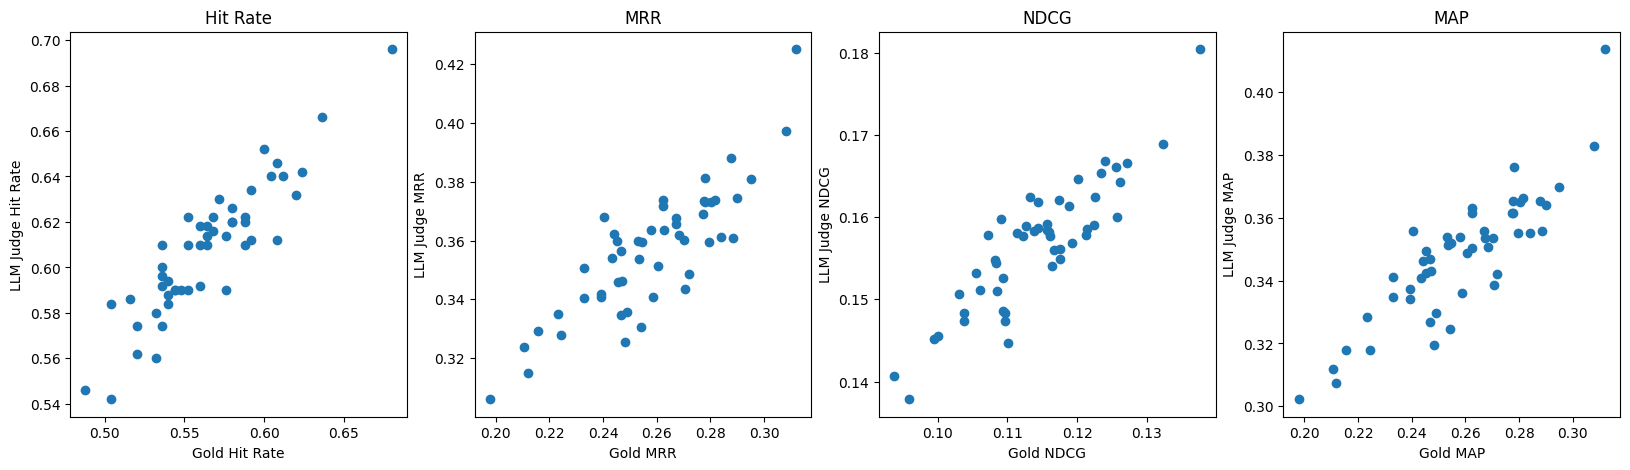

In [12]:

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.scatter(gold_hit_rates, llm_judge_hit_rates)
plt.xlabel("Gold Hit Rate")
plt.ylabel("LLM Judge Hit Rate")
plt.title("Hit Rate")
plt.subplot(1, 4, 2)
plt.scatter(gold_mrrs, llm_judge_mrrs)
plt.xlabel("Gold MRR")
plt.ylabel("LLM Judge MRR")
plt.title("MRR")
plt.subplot(1, 4, 3)
plt.scatter(gold_ndcgs, llm_judge_ndcgs)
plt.xlabel("Gold NDCG")
plt.ylabel("LLM Judge NDCG")
plt.title("NDCG")
plt.subplot(1, 4, 4)
plt.scatter(gold_maps, llm_judge_maps)
plt.xlabel("Gold MAP")
plt.ylabel("LLM Judge MAP")
plt.title("MAP")
plt.show()

In [13]:
print("Binary judge (>0.5)")
pd.DataFrame([
    { "metric": "hit_rate", "gold": np.mean(gold_hit_rates), "llm_judge": np.mean(binary_llm_judge_hit_rates), "correlation": pearsonr(gold_hit_rates, binary_llm_judge_hit_rates).statistic },
    { "metric": "mrr", "gold": np.mean(gold_mrrs), "llm_judge": np.mean(binary_llm_judge_mrrs), "correlation": pearsonr(gold_mrrs, binary_llm_judge_mrrs).statistic },
    { "metric": "ndcg", "gold": np.mean(gold_ndcgs), "llm_judge": np.mean(binary_llm_judge_ndcgs), "correlation": pearsonr(gold_ndcgs, binary_llm_judge_ndcgs).statistic },
    { "metric": "map", "gold": np.mean(gold_maps), "llm_judge": np.mean(binary_llm_judge_maps), "correlation": pearsonr(gold_maps, binary_llm_judge_maps).statistic},
    ])

Binary judge (>0.5)


,metric,gold,llm_judge,correlation
0,hit_rate,0.564400,0.541440,0.895280
1,mrr,0.257917,0.256475,0.921671
2,ndcg,0.114198,0.120678,0.889416
3,map,0.257917,0.254326,0.930107


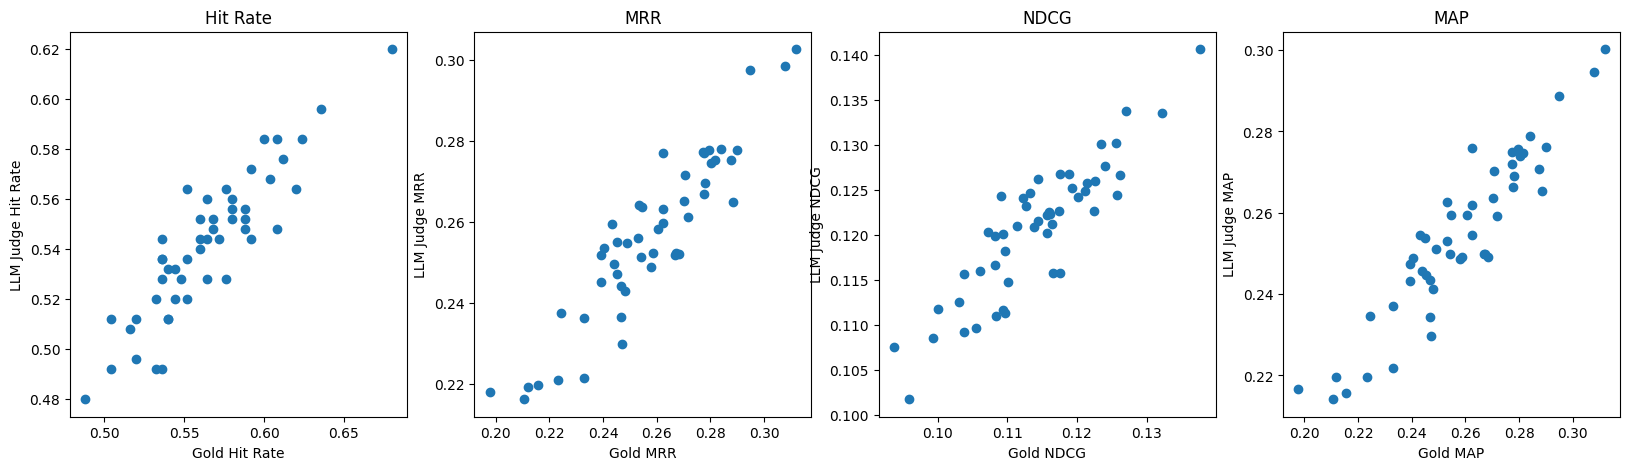

In [14]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.scatter(gold_hit_rates, binary_llm_judge_hit_rates)
plt.xlabel("Gold Hit Rate")
plt.ylabel("LLM Judge Hit Rate")
plt.title("Hit Rate")
plt.subplot(1, 4, 2)
plt.scatter(gold_mrrs, binary_llm_judge_mrrs)
plt.xlabel("Gold MRR")
plt.ylabel("LLM Judge MRR")
plt.title("MRR")
plt.subplot(1, 4, 3)
plt.scatter(gold_ndcgs, binary_llm_judge_ndcgs)
plt.xlabel("Gold NDCG")
plt.ylabel("LLM Judge NDCG")
plt.title("NDCG")
plt.subplot(1, 4, 4)
plt.scatter(gold_maps, binary_llm_judge_maps)
plt.xlabel("Gold MAP")
plt.ylabel("LLM Judge MAP")
plt.title("MAP")
plt.show()

### partial vs not_relevant

In [15]:
gold_hit_rates = []
gold_mrrs = []
gold_ndcgs = []
gold_maps = []

llm_judge_hit_rates = []
llm_judge_mrrs = []
llm_judge_ndcgs = []
llm_judge_maps = []

binary_llm_judge_hit_rates = []
binary_llm_judge_mrrs = []
binary_llm_judge_ndcgs = []
binary_llm_judge_maps = []

k = 50
top_k = 5
random.seed(42)

# only partially_relevant and not_relevant
label_types = ["gold_context_part", "distractor_context_part"]
for _ in range(k):
    gold_hit_rate_per_query = []
    gold_mrr_per_query = []
    gold_ndcg_per_query = []
    gold_maps_per_query = []

    llm_judge_hit_rate_per_query = []
    llm_judge_mrr_per_query = []
    llm_judge_ndcg_per_query = []
    llm_judge_map_per_query = []

    binary_llm_judge_hit_rate_per_query = []
    binary_llm_judge_mrr_per_query = []
    binary_llm_judge_ndcg_per_query = []
    binary_llm_judge_map_per_query = []

    for id in all_sampled_ids:
        id_sample = [entry for entry in sampled_context_relevance_ds if entry["id"] == id and entry["type"] in label_types]
        random.shuffle(id_sample)
        simulated_hit_list = id_sample[:top_k]

        gold_values = [entry["relevance_value"] for entry in simulated_hit_list]
        llm_judge_ratings = [entry["llm_judge_rating"] for entry in simulated_hit_list]
        binary_judge_ratings = [1 if rating > 0.0 else 0 for rating in llm_judge_ratings]

        gold_hit_rate = hit_rate(gold_values)
        llm_judge_hit_rate = hit_rate(llm_judge_ratings)
        binary_llm_judge_hit_rate = hit_rate(binary_judge_ratings)
        gold_mrr = mrr(gold_values)
        llm_judge_mrr = mrr(llm_judge_ratings)
        binary_llm_judge_mrr = mrr(binary_judge_ratings)
        gold_ndcg = ndcg(gold_values)
        llm_judge_ndcg = ndcg(llm_judge_ratings)
        binary_llm_judge_ndcg = ndcg(binary_judge_ratings)
        gold_map_score = mean_average_precision(gold_values)
        llm_judge_map_score = mean_average_precision(llm_judge_ratings)
        binary_llm_judge_map_score = mean_average_precision(binary_judge_ratings)

        gold_hit_rate_per_query.append(gold_hit_rate)
        llm_judge_hit_rate_per_query.append(llm_judge_hit_rate)
        binary_llm_judge_hit_rate_per_query.append(binary_llm_judge_hit_rate)
        gold_mrr_per_query.append(gold_mrr)
        llm_judge_mrr_per_query.append(llm_judge_mrr)
        binary_llm_judge_mrr_per_query.append(binary_llm_judge_mrr)
        gold_ndcg_per_query.append(gold_ndcg)
        llm_judge_ndcg_per_query.append(llm_judge_ndcg)
        binary_llm_judge_ndcg_per_query.append(binary_llm_judge_ndcg)
        gold_maps_per_query.append(gold_map_score)
        llm_judge_map_per_query.append(llm_judge_map_score)
        binary_llm_judge_map_per_query.append(binary_llm_judge_map_score)

    gold_hit_rates.append(np.mean(gold_hit_rate_per_query))
    gold_mrrs.append(np.mean(gold_mrr_per_query))
    gold_ndcgs.append(np.mean(gold_ndcg_per_query))
    gold_maps.append(np.mean(gold_maps_per_query))
    llm_judge_hit_rates.append(np.mean(llm_judge_hit_rate_per_query))
    llm_judge_mrrs.append(np.mean(llm_judge_mrr_per_query))
    llm_judge_ndcgs.append(np.mean(llm_judge_ndcg_per_query))
    llm_judge_maps.append(np.mean(llm_judge_map_per_query))
    binary_llm_judge_hit_rates.append(np.mean(binary_llm_judge_hit_rate_per_query))
    binary_llm_judge_mrrs.append(np.mean(binary_llm_judge_mrr_per_query))
    binary_llm_judge_ndcgs.append(np.mean(binary_llm_judge_ndcg_per_query))
    binary_llm_judge_maps.append(np.mean(binary_llm_judge_map_per_query))


In [16]:
pd.DataFrame([
    { "metric": "hit_rate", "gold": np.mean(gold_hit_rates), "llm_judge": np.mean(llm_judge_hit_rates), "correlation": pearsonr(gold_hit_rates, llm_judge_hit_rates).statistic },
    { "metric": "mrr", "gold": np.mean(gold_mrrs), "llm_judge": np.mean(llm_judge_mrrs), "correlation": pearsonr(gold_mrrs, llm_judge_mrrs).statistic },
    { "metric": "ndcg", "gold": np.mean(gold_ndcgs), "llm_judge": np.mean(llm_judge_ndcgs), "correlation": pearsonr(gold_ndcgs, llm_judge_ndcgs).statistic },
    { "metric": "map", "gold": np.mean(gold_maps), "llm_judge": np.mean(llm_judge_maps), "correlation": pearsonr(gold_maps, llm_judge_maps).statistic},
    ])

,metric,gold,llm_judge,correlation
0,hit_rate,0.410120,0.551240,0.664668
1,mrr,0.435792,0.411171,0.719568
2,ndcg,0.116589,0.166793,0.640233
3,map,0.420891,0.396870,0.758260


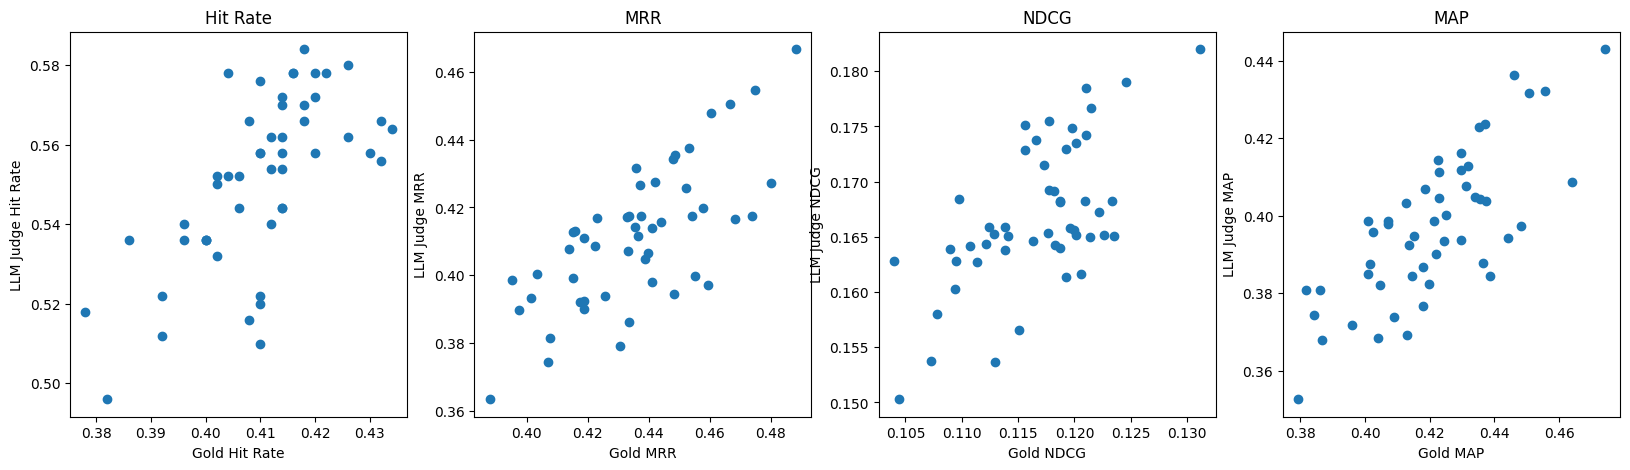

In [17]:

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.scatter(gold_hit_rates, llm_judge_hit_rates)
plt.xlabel("Gold Hit Rate")
plt.ylabel("LLM Judge Hit Rate")
plt.title("Hit Rate")
plt.subplot(1, 4, 2)
plt.scatter(gold_mrrs, llm_judge_mrrs)
plt.xlabel("Gold MRR")
plt.ylabel("LLM Judge MRR")
plt.title("MRR")
plt.subplot(1, 4, 3)
plt.scatter(gold_ndcgs, llm_judge_ndcgs)
plt.xlabel("Gold NDCG")
plt.ylabel("LLM Judge NDCG")
plt.title("NDCG")
plt.subplot(1, 4, 4)
plt.scatter(gold_maps, llm_judge_maps)
plt.xlabel("Gold MAP")
plt.ylabel("LLM Judge MAP")
plt.title("MAP")
plt.show()

In [18]:
print("Binary judge (>0.0)")
pd.DataFrame([
    { "metric": "hit_rate", "gold": np.mean(gold_hit_rates), "llm_judge": np.mean(binary_llm_judge_hit_rates), "correlation": pearsonr(gold_hit_rates, binary_llm_judge_hit_rates).statistic },
    { "metric": "mrr", "gold": np.mean(gold_mrrs), "llm_judge": np.mean(binary_llm_judge_mrrs), "correlation": pearsonr(gold_mrrs, binary_llm_judge_mrrs).statistic },
    { "metric": "ndcg", "gold": np.mean(gold_ndcgs), "llm_judge": np.mean(binary_llm_judge_ndcgs), "correlation": pearsonr(gold_ndcgs, binary_llm_judge_ndcgs).statistic },
    { "metric": "map", "gold": np.mean(gold_maps), "llm_judge": np.mean(binary_llm_judge_maps), "correlation": pearsonr(gold_maps, binary_llm_judge_maps).statistic},
    ])

Binary judge (>0.0)


,metric,gold,llm_judge,correlation
0,hit_rate,0.410120,0.731840,0.674347
1,mrr,0.435792,0.411171,0.719568
2,ndcg,0.116589,0.239207,0.686612
3,map,0.420891,0.396870,0.758260


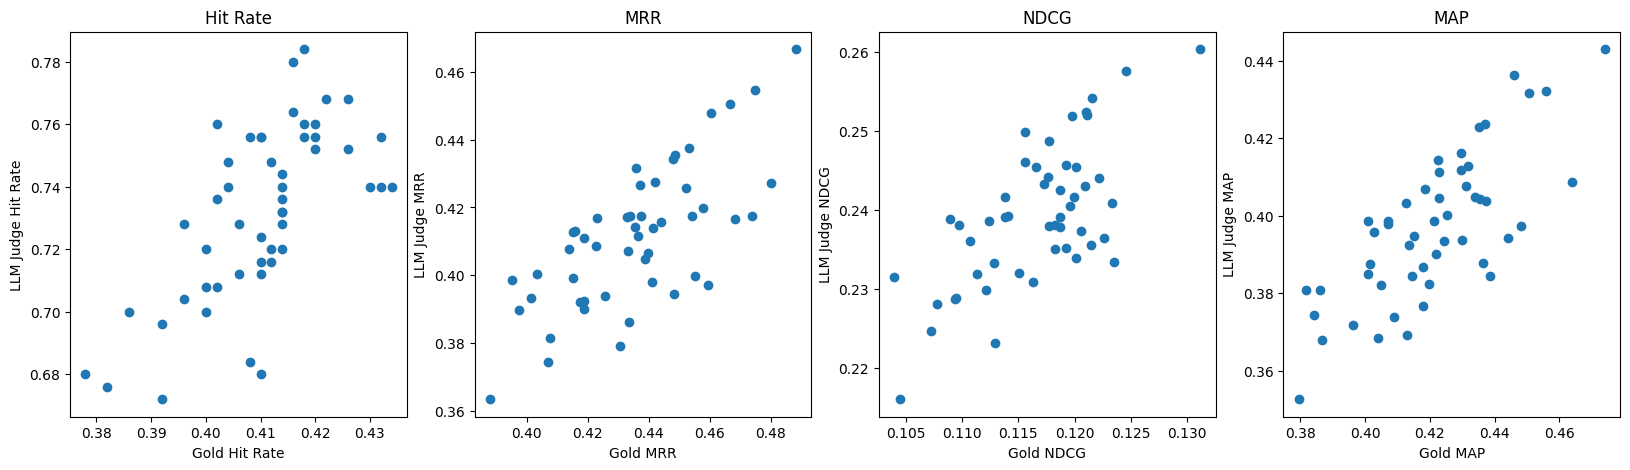

In [19]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.scatter(gold_hit_rates, binary_llm_judge_hit_rates)
plt.xlabel("Gold Hit Rate")
plt.ylabel("LLM Judge Hit Rate")
plt.title("Hit Rate")
plt.subplot(1, 4, 2)
plt.scatter(gold_mrrs, binary_llm_judge_mrrs)
plt.xlabel("Gold MRR")
plt.ylabel("LLM Judge MRR")
plt.title("MRR")
plt.subplot(1, 4, 3)
plt.scatter(gold_ndcgs, binary_llm_judge_ndcgs)
plt.xlabel("Gold NDCG")
plt.ylabel("LLM Judge NDCG")
plt.title("NDCG")
plt.subplot(1, 4, 4)
plt.scatter(gold_maps, binary_llm_judge_maps)
plt.xlabel("Gold MAP")
plt.ylabel("LLM Judge MAP")
plt.title("MAP")
plt.show()

## Claude Sonnet 3.5

In [20]:
import pandas as pd

df = pd.read_csv("../../data/context_relevance/llm_judge_hotpot_qa_distractor_validation_sonnet3.5.csv")
sampled_context_relevance_ds = df.to_dict(orient="records")

all_sampled_ids = set(entry["id"] for entry in sampled_context_relevance_ds)
len(all_sampled_ids)

250

### raw labels

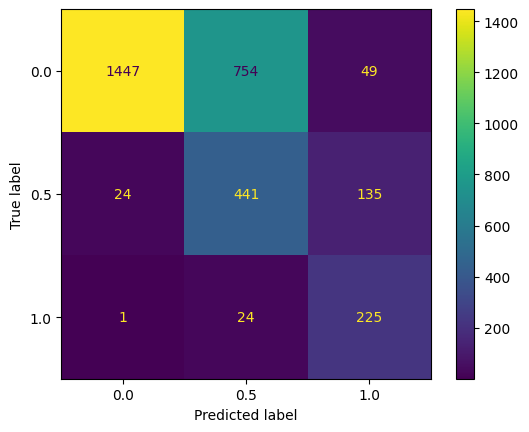

In [21]:
gold_labels = [entry["relevance_value"] for entry in sampled_context_relevance_ds]
llm_judge_labels = [entry["llm_judge_rating"] for entry in sampled_context_relevance_ds]

def to_category(value):
    return str(value)

cm = confusion_matrix(list(map(to_category, gold_labels)), list(map(to_category, llm_judge_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0.0", "0.5", "1.0"])
disp.plot()

### all labels

In [22]:
gold_hit_rates = []
gold_mrrs = []
gold_ndcgs = []
gold_maps = []

llm_judge_hit_rates = []
llm_judge_mrrs = []
llm_judge_ndcgs = []
llm_judge_maps = []

binary_llm_judge_hit_rates = []
binary_llm_judge_mrrs = []
binary_llm_judge_ndcgs = []
binary_llm_judge_maps = []

k = 50
top_k = 5
random.seed(42)

# only fully_relevant and not_relevant
label_types = ["gold_context_full", "gold_context_part", "distractor_context_part"]
for _ in range(k):
    gold_hit_rate_per_query = []
    gold_mrr_per_query = []
    gold_ndcg_per_query = []
    gold_maps_per_query = []

    llm_judge_hit_rate_per_query = []
    llm_judge_mrr_per_query = []
    llm_judge_ndcg_per_query = []
    llm_judge_map_per_query = []

    binary_llm_judge_hit_rate_per_query = []
    binary_llm_judge_mrr_per_query = []
    binary_llm_judge_ndcg_per_query = []
    binary_llm_judge_map_per_query = []

    for id in all_sampled_ids:
        id_sample = [entry for entry in sampled_context_relevance_ds if entry["id"] == id and entry["type"] in label_types]
        random.shuffle(id_sample)
        simulated_hit_list = id_sample[:top_k]

        gold_values = [entry["relevance_value"] for entry in simulated_hit_list]
        llm_judge_ratings = [entry["llm_judge_rating"] for entry in simulated_hit_list]
        binary_judge_ratings = [1 if rating > 0.5 else 0 for rating in llm_judge_ratings]

        gold_hit_rate = hit_rate(gold_values)
        llm_judge_hit_rate = hit_rate(llm_judge_ratings)
        binary_llm_judge_hit_rate = hit_rate(binary_judge_ratings)
        gold_mrr = mrr(gold_values)
        llm_judge_mrr = mrr(llm_judge_ratings)
        binary_llm_judge_mrr = mrr(binary_judge_ratings)
        gold_ndcg = ndcg(gold_values)
        llm_judge_ndcg = ndcg(llm_judge_ratings)
        binary_llm_judge_ndcg = ndcg(binary_judge_ratings)
        gold_map_score = mean_average_precision(gold_values)
        llm_judge_map_score = mean_average_precision(llm_judge_ratings)
        binary_llm_judge_map_score = mean_average_precision(binary_judge_ratings)

        gold_hit_rate_per_query.append(gold_hit_rate)
        llm_judge_hit_rate_per_query.append(llm_judge_hit_rate)
        binary_llm_judge_hit_rate_per_query.append(binary_llm_judge_hit_rate)
        gold_mrr_per_query.append(gold_mrr)
        llm_judge_mrr_per_query.append(llm_judge_mrr)
        binary_llm_judge_mrr_per_query.append(binary_llm_judge_mrr)
        gold_ndcg_per_query.append(gold_ndcg)
        llm_judge_ndcg_per_query.append(llm_judge_ndcg)
        binary_llm_judge_ndcg_per_query.append(binary_llm_judge_ndcg)
        gold_maps_per_query.append(gold_map_score)
        llm_judge_map_per_query.append(llm_judge_map_score)
        binary_llm_judge_map_per_query.append(binary_llm_judge_map_score)

    gold_hit_rates.append(np.mean(gold_hit_rate_per_query))
    gold_mrrs.append(np.mean(gold_mrr_per_query))
    gold_ndcgs.append(np.mean(gold_ndcg_per_query))
    gold_maps.append(np.mean(gold_maps_per_query))
    llm_judge_hit_rates.append(np.mean(llm_judge_hit_rate_per_query))
    llm_judge_mrrs.append(np.mean(llm_judge_mrr_per_query))
    llm_judge_ndcgs.append(np.mean(llm_judge_ndcg_per_query))
    llm_judge_maps.append(np.mean(llm_judge_map_per_query))
    binary_llm_judge_hit_rates.append(np.mean(binary_llm_judge_hit_rate_per_query))
    binary_llm_judge_mrrs.append(np.mean(binary_llm_judge_mrr_per_query))
    binary_llm_judge_ndcgs.append(np.mean(binary_llm_judge_ndcg_per_query))
    binary_llm_judge_maps.append(np.mean(binary_llm_judge_map_per_query))


In [23]:
pd.DataFrame([
    { "metric": "hit_rate", "gold": np.mean(gold_hit_rates), "llm_judge": np.mean(llm_judge_hit_rates), "correlation": pearsonr(gold_hit_rates, llm_judge_hit_rates).statistic },
    { "metric": "mrr", "gold": np.mean(gold_mrrs), "llm_judge": np.mean(llm_judge_mrrs), "correlation": pearsonr(gold_mrrs, llm_judge_mrrs).statistic },
    { "metric": "ndcg", "gold": np.mean(gold_ndcgs), "llm_judge": np.mean(llm_judge_ndcgs), "correlation": pearsonr(gold_ndcgs, llm_judge_ndcgs).statistic },
    { "metric": "map", "gold": np.mean(gold_maps), "llm_judge": np.mean(llm_judge_maps), "correlation": pearsonr(gold_maps, llm_judge_maps).statistic},
    ])

,metric,gold,llm_judge,correlation
0,hit_rate,0.669760,0.756680,0.523211
1,mrr,0.509679,0.692535,0.710095
2,ndcg,0.191085,0.328680,0.627702
3,map,0.485582,0.659766,0.712640


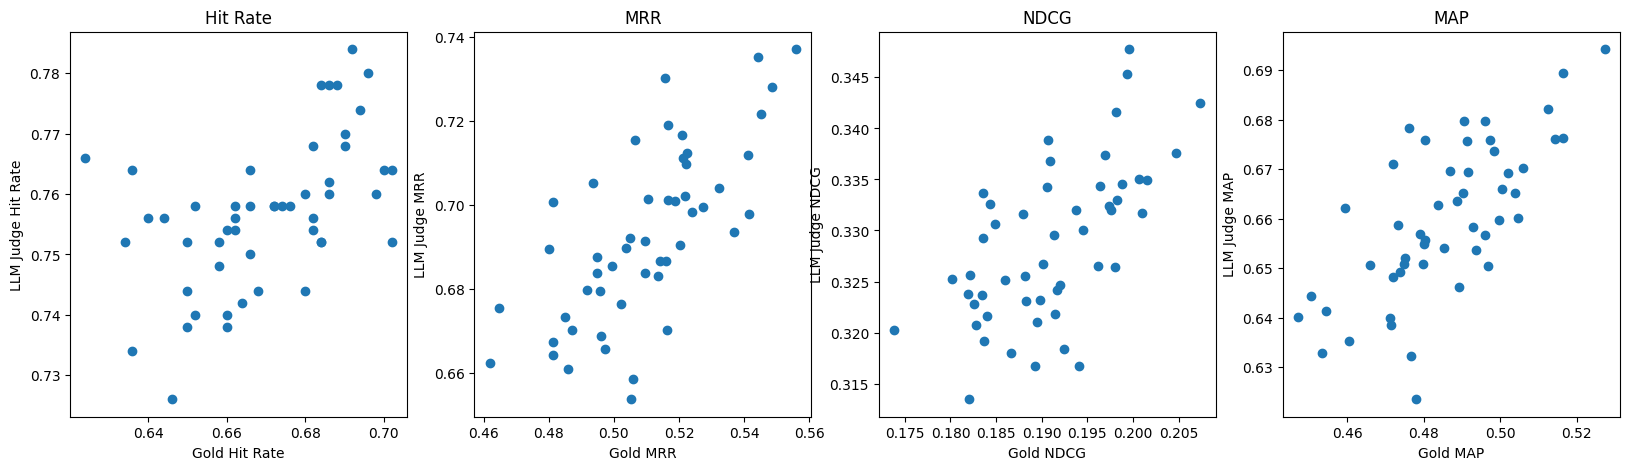

In [24]:

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.scatter(gold_hit_rates, llm_judge_hit_rates)
plt.xlabel("Gold Hit Rate")
plt.ylabel("LLM Judge Hit Rate")
plt.title("Hit Rate")
plt.subplot(1, 4, 2)
plt.scatter(gold_mrrs, llm_judge_mrrs)
plt.xlabel("Gold MRR")
plt.ylabel("LLM Judge MRR")
plt.title("MRR")
plt.subplot(1, 4, 3)
plt.scatter(gold_ndcgs, llm_judge_ndcgs)
plt.xlabel("Gold NDCG")
plt.ylabel("LLM Judge NDCG")
plt.title("NDCG")
plt.subplot(1, 4, 4)
plt.scatter(gold_maps, llm_judge_maps)
plt.xlabel("Gold MAP")
plt.ylabel("LLM Judge MAP")
plt.title("MAP")
plt.show()

In [25]:
print("Binary judge (>0.5)")
pd.DataFrame([
    { "metric": "hit_rate", "gold": np.mean(gold_hit_rates), "llm_judge": np.mean(binary_llm_judge_hit_rates), "correlation": pearsonr(gold_hit_rates, binary_llm_judge_hit_rates).statistic },
    { "metric": "mrr", "gold": np.mean(gold_mrrs), "llm_judge": np.mean(binary_llm_judge_mrrs), "correlation": pearsonr(gold_mrrs, binary_llm_judge_mrrs).statistic },
    { "metric": "ndcg", "gold": np.mean(gold_ndcgs), "llm_judge": np.mean(binary_llm_judge_ndcgs), "correlation": pearsonr(gold_ndcgs, binary_llm_judge_ndcgs).statistic },
    { "metric": "map", "gold": np.mean(gold_maps), "llm_judge": np.mean(binary_llm_judge_maps), "correlation": pearsonr(gold_maps, binary_llm_judge_maps).statistic},
    ])

Binary judge (>0.5)


,metric,gold,llm_judge,correlation
0,hit_rate,0.669760,0.550000,0.518495
1,mrr,0.509679,0.272927,0.538607
2,ndcg,0.191085,0.137004,0.560585
3,map,0.485582,0.267343,0.482002


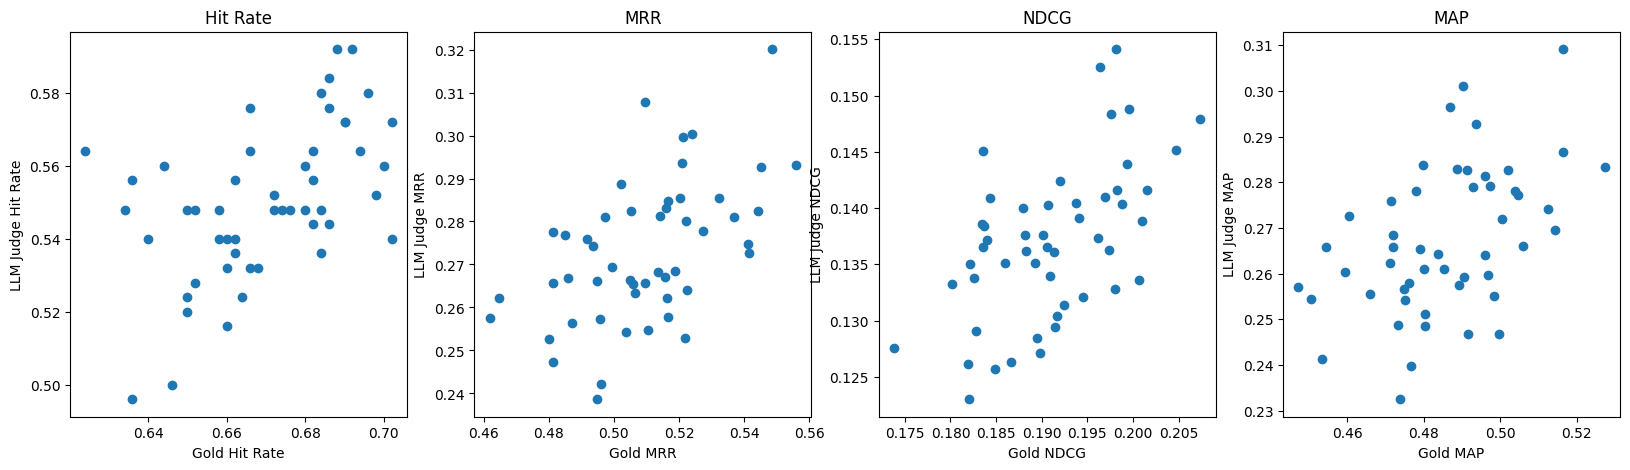

In [26]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.scatter(gold_hit_rates, binary_llm_judge_hit_rates)
plt.xlabel("Gold Hit Rate")
plt.ylabel("LLM Judge Hit Rate")
plt.title("Hit Rate")
plt.subplot(1, 4, 2)
plt.scatter(gold_mrrs, binary_llm_judge_mrrs)
plt.xlabel("Gold MRR")
plt.ylabel("LLM Judge MRR")
plt.title("MRR")
plt.subplot(1, 4, 3)
plt.scatter(gold_ndcgs, binary_llm_judge_ndcgs)
plt.xlabel("Gold NDCG")
plt.ylabel("LLM Judge NDCG")
plt.title("NDCG")
plt.subplot(1, 4, 4)
plt.scatter(gold_maps, binary_llm_judge_maps)
plt.xlabel("Gold MAP")
plt.ylabel("LLM Judge MAP")
plt.title("MAP")
plt.show()

### full vs not_relevant

In [27]:
gold_hit_rates = []
gold_mrrs = []
gold_ndcgs = []
gold_maps = []

llm_judge_hit_rates = []
llm_judge_mrrs = []
llm_judge_ndcgs = []
llm_judge_maps = []

binary_llm_judge_hit_rates = []
binary_llm_judge_mrrs = []
binary_llm_judge_ndcgs = []
binary_llm_judge_maps = []

k = 50
top_k = 5
random.seed(42)

# only fully_relevant and not_relevant
label_types = ["gold_context_full", "distractor_context_part"]
for _ in range(k):
    gold_hit_rate_per_query = []
    gold_mrr_per_query = []
    gold_ndcg_per_query = []
    gold_maps_per_query = []

    llm_judge_hit_rate_per_query = []
    llm_judge_mrr_per_query = []
    llm_judge_ndcg_per_query = []
    llm_judge_map_per_query = []

    binary_llm_judge_hit_rate_per_query = []
    binary_llm_judge_mrr_per_query = []
    binary_llm_judge_ndcg_per_query = []
    binary_llm_judge_map_per_query = []

    for id in all_sampled_ids:
        id_sample = [entry for entry in sampled_context_relevance_ds if entry["id"] == id and entry["type"] in label_types]
        random.shuffle(id_sample)
        simulated_hit_list = id_sample[:top_k]

        gold_values = [entry["relevance_value"] for entry in simulated_hit_list]
        llm_judge_ratings = [entry["llm_judge_rating"] for entry in simulated_hit_list]
        binary_judge_ratings = [1 if rating > 0.5 else 0 for rating in llm_judge_ratings]

        gold_hit_rate = hit_rate(gold_values)
        llm_judge_hit_rate = hit_rate(llm_judge_ratings)
        binary_llm_judge_hit_rate = hit_rate(binary_judge_ratings)
        gold_mrr = mrr(gold_values)
        llm_judge_mrr = mrr(llm_judge_ratings)
        binary_llm_judge_mrr = mrr(binary_judge_ratings)
        gold_ndcg = ndcg(gold_values)
        llm_judge_ndcg = ndcg(llm_judge_ratings)
        binary_llm_judge_ndcg = ndcg(binary_judge_ratings)
        gold_map_score = mean_average_precision(gold_values)
        llm_judge_map_score = mean_average_precision(llm_judge_ratings)
        binary_llm_judge_map_score = mean_average_precision(binary_judge_ratings)

        gold_hit_rate_per_query.append(gold_hit_rate)
        llm_judge_hit_rate_per_query.append(llm_judge_hit_rate)
        binary_llm_judge_hit_rate_per_query.append(binary_llm_judge_hit_rate)
        gold_mrr_per_query.append(gold_mrr)
        llm_judge_mrr_per_query.append(llm_judge_mrr)
        binary_llm_judge_mrr_per_query.append(binary_llm_judge_mrr)
        gold_ndcg_per_query.append(gold_ndcg)
        llm_judge_ndcg_per_query.append(llm_judge_ndcg)
        binary_llm_judge_ndcg_per_query.append(binary_llm_judge_ndcg)
        gold_maps_per_query.append(gold_map_score)
        llm_judge_map_per_query.append(llm_judge_map_score)
        binary_llm_judge_map_per_query.append(binary_llm_judge_map_score)

    gold_hit_rates.append(np.mean(gold_hit_rate_per_query))
    gold_mrrs.append(np.mean(gold_mrr_per_query))
    gold_ndcgs.append(np.mean(gold_ndcg_per_query))
    gold_maps.append(np.mean(gold_maps_per_query))
    llm_judge_hit_rates.append(np.mean(llm_judge_hit_rate_per_query))
    llm_judge_mrrs.append(np.mean(llm_judge_mrr_per_query))
    llm_judge_ndcgs.append(np.mean(llm_judge_ndcg_per_query))
    llm_judge_maps.append(np.mean(llm_judge_map_per_query))
    binary_llm_judge_hit_rates.append(np.mean(binary_llm_judge_hit_rate_per_query))
    binary_llm_judge_mrrs.append(np.mean(binary_llm_judge_mrr_per_query))
    binary_llm_judge_ndcgs.append(np.mean(binary_llm_judge_ndcg_per_query))
    binary_llm_judge_maps.append(np.mean(binary_llm_judge_map_per_query))


In [28]:
pd.DataFrame([
    { "metric": "hit_rate", "gold": np.mean(gold_hit_rates), "llm_judge": np.mean(llm_judge_hit_rates), "correlation": pearsonr(gold_hit_rates, llm_judge_hit_rates).statistic },
    { "metric": "mrr", "gold": np.mean(gold_mrrs), "llm_judge": np.mean(llm_judge_mrrs), "correlation": pearsonr(gold_mrrs, llm_judge_mrrs).statistic },
    { "metric": "ndcg", "gold": np.mean(gold_ndcgs), "llm_judge": np.mean(llm_judge_ndcgs), "correlation": pearsonr(gold_ndcgs, llm_judge_ndcgs).statistic },
    { "metric": "map", "gold": np.mean(gold_maps), "llm_judge": np.mean(llm_judge_maps), "correlation": pearsonr(gold_maps, llm_judge_maps).statistic},
    ])

,metric,gold,llm_judge,correlation
0,hit_rate,0.559360,0.695880,0.853168
1,mrr,0.253361,0.575408,0.674288
2,ndcg,0.111341,0.261189,0.850708
3,map,0.253361,0.552427,0.655618


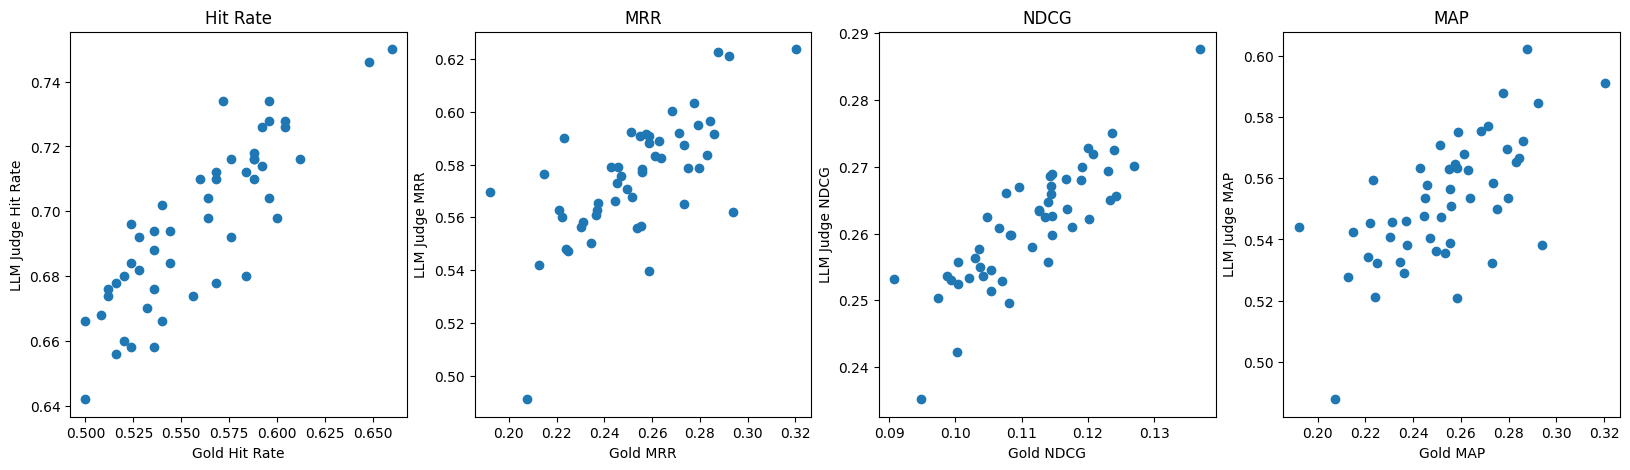

In [29]:

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.scatter(gold_hit_rates, llm_judge_hit_rates)
plt.xlabel("Gold Hit Rate")
plt.ylabel("LLM Judge Hit Rate")
plt.title("Hit Rate")
plt.subplot(1, 4, 2)
plt.scatter(gold_mrrs, llm_judge_mrrs)
plt.xlabel("Gold MRR")
plt.ylabel("LLM Judge MRR")
plt.title("MRR")
plt.subplot(1, 4, 3)
plt.scatter(gold_ndcgs, llm_judge_ndcgs)
plt.xlabel("Gold NDCG")
plt.ylabel("LLM Judge NDCG")
plt.title("NDCG")
plt.subplot(1, 4, 4)
plt.scatter(gold_maps, llm_judge_maps)
plt.xlabel("Gold MAP")
plt.ylabel("LLM Judge MAP")
plt.title("MAP")
plt.show()

In [30]:
print("Binary judge (>0.5)")
pd.DataFrame([
    { "metric": "hit_rate", "gold": np.mean(gold_hit_rates), "llm_judge": np.mean(binary_llm_judge_hit_rates), "correlation": pearsonr(gold_hit_rates, binary_llm_judge_hit_rates).statistic },
    { "metric": "mrr", "gold": np.mean(gold_mrrs), "llm_judge": np.mean(binary_llm_judge_mrrs), "correlation": pearsonr(gold_mrrs, binary_llm_judge_mrrs).statistic },
    { "metric": "ndcg", "gold": np.mean(gold_ndcgs), "llm_judge": np.mean(binary_llm_judge_ndcgs), "correlation": pearsonr(gold_ndcgs, binary_llm_judge_ndcgs).statistic },
    { "metric": "map", "gold": np.mean(gold_maps), "llm_judge": np.mean(binary_llm_judge_maps), "correlation": pearsonr(gold_maps, binary_llm_judge_maps).statistic},
    ])

Binary judge (>0.5)


,metric,gold,llm_judge,correlation
0,hit_rate,0.559360,0.529680,0.922322
1,mrr,0.253361,0.249771,0.935339
2,ndcg,0.111341,0.115293,0.934729
3,map,0.253361,0.247915,0.939047


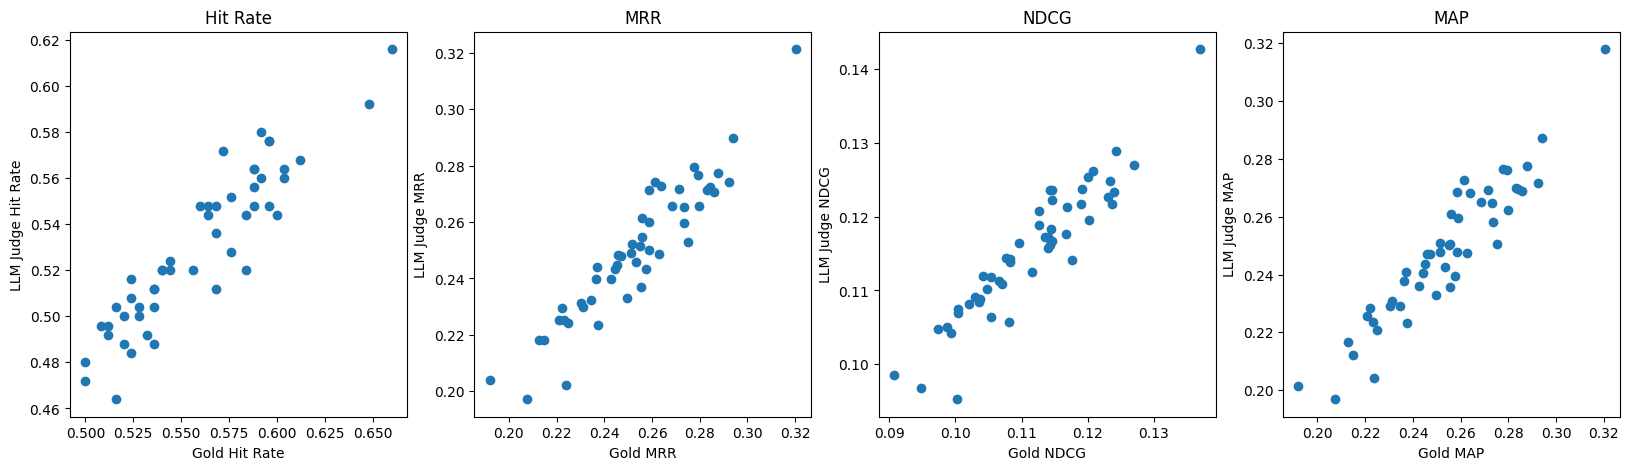

In [31]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.scatter(gold_hit_rates, binary_llm_judge_hit_rates)
plt.xlabel("Gold Hit Rate")
plt.ylabel("LLM Judge Hit Rate")
plt.title("Hit Rate")
plt.subplot(1, 4, 2)
plt.scatter(gold_mrrs, binary_llm_judge_mrrs)
plt.xlabel("Gold MRR")
plt.ylabel("LLM Judge MRR")
plt.title("MRR")
plt.subplot(1, 4, 3)
plt.scatter(gold_ndcgs, binary_llm_judge_ndcgs)
plt.xlabel("Gold NDCG")
plt.ylabel("LLM Judge NDCG")
plt.title("NDCG")
plt.subplot(1, 4, 4)
plt.scatter(gold_maps, binary_llm_judge_maps)
plt.xlabel("Gold MAP")
plt.ylabel("LLM Judge MAP")
plt.title("MAP")
plt.show()

### partial vs not_relevant

In [32]:
gold_hit_rates = []
gold_mrrs = []
gold_ndcgs = []
gold_maps = []

llm_judge_hit_rates = []
llm_judge_mrrs = []
llm_judge_ndcgs = []
llm_judge_maps = []

binary_llm_judge_hit_rates = []
binary_llm_judge_mrrs = []
binary_llm_judge_ndcgs = []
binary_llm_judge_maps = []

k = 50
top_k = 5
random.seed(42)

# only partially_relevant and not_relevant
label_types = ["gold_context_part", "distractor_context_part"]
for _ in range(k):
    gold_hit_rate_per_query = []
    gold_mrr_per_query = []
    gold_ndcg_per_query = []
    gold_maps_per_query = []

    llm_judge_hit_rate_per_query = []
    llm_judge_mrr_per_query = []
    llm_judge_ndcg_per_query = []
    llm_judge_map_per_query = []

    binary_llm_judge_hit_rate_per_query = []
    binary_llm_judge_mrr_per_query = []
    binary_llm_judge_ndcg_per_query = []
    binary_llm_judge_map_per_query = []

    for id in all_sampled_ids:
        id_sample = [entry for entry in sampled_context_relevance_ds if entry["id"] == id and entry["type"] in label_types]
        random.shuffle(id_sample)
        simulated_hit_list = id_sample[:top_k]

        gold_values = [entry["relevance_value"] for entry in simulated_hit_list]
        llm_judge_ratings = [entry["llm_judge_rating"] for entry in simulated_hit_list]
        binary_judge_ratings = [1 if rating > 0.0 else 0 for rating in llm_judge_ratings]

        gold_hit_rate = hit_rate(gold_values)
        llm_judge_hit_rate = hit_rate(llm_judge_ratings)
        binary_llm_judge_hit_rate = hit_rate(binary_judge_ratings)
        gold_mrr = mrr(gold_values)
        llm_judge_mrr = mrr(llm_judge_ratings)
        binary_llm_judge_mrr = mrr(binary_judge_ratings)
        gold_ndcg = ndcg(gold_values)
        llm_judge_ndcg = ndcg(llm_judge_ratings)
        binary_llm_judge_ndcg = ndcg(binary_judge_ratings)
        gold_map_score = mean_average_precision(gold_values)
        llm_judge_map_score = mean_average_precision(llm_judge_ratings)
        binary_llm_judge_map_score = mean_average_precision(binary_judge_ratings)

        gold_hit_rate_per_query.append(gold_hit_rate)
        llm_judge_hit_rate_per_query.append(llm_judge_hit_rate)
        binary_llm_judge_hit_rate_per_query.append(binary_llm_judge_hit_rate)
        gold_mrr_per_query.append(gold_mrr)
        llm_judge_mrr_per_query.append(llm_judge_mrr)
        binary_llm_judge_mrr_per_query.append(binary_llm_judge_mrr)
        gold_ndcg_per_query.append(gold_ndcg)
        llm_judge_ndcg_per_query.append(llm_judge_ndcg)
        binary_llm_judge_ndcg_per_query.append(binary_llm_judge_ndcg)
        gold_maps_per_query.append(gold_map_score)
        llm_judge_map_per_query.append(llm_judge_map_score)
        binary_llm_judge_map_per_query.append(binary_llm_judge_map_score)

    gold_hit_rates.append(np.mean(gold_hit_rate_per_query))
    gold_mrrs.append(np.mean(gold_mrr_per_query))
    gold_ndcgs.append(np.mean(gold_ndcg_per_query))
    gold_maps.append(np.mean(gold_maps_per_query))
    llm_judge_hit_rates.append(np.mean(llm_judge_hit_rate_per_query))
    llm_judge_mrrs.append(np.mean(llm_judge_mrr_per_query))
    llm_judge_ndcgs.append(np.mean(llm_judge_ndcg_per_query))
    llm_judge_maps.append(np.mean(llm_judge_map_per_query))
    binary_llm_judge_hit_rates.append(np.mean(binary_llm_judge_hit_rate_per_query))
    binary_llm_judge_mrrs.append(np.mean(binary_llm_judge_mrr_per_query))
    binary_llm_judge_ndcgs.append(np.mean(binary_llm_judge_ndcg_per_query))
    binary_llm_judge_maps.append(np.mean(binary_llm_judge_map_per_query))


In [33]:
pd.DataFrame([
    { "metric": "hit_rate", "gold": np.mean(gold_hit_rates), "llm_judge": np.mean(llm_judge_hit_rates), "correlation": pearsonr(gold_hit_rates, llm_judge_hit_rates).statistic },
    { "metric": "mrr", "gold": np.mean(gold_mrrs), "llm_judge": np.mean(llm_judge_mrrs), "correlation": pearsonr(gold_mrrs, llm_judge_mrrs).statistic },
    { "metric": "ndcg", "gold": np.mean(gold_ndcgs), "llm_judge": np.mean(llm_judge_ndcgs), "correlation": pearsonr(gold_ndcgs, llm_judge_ndcgs).statistic },
    { "metric": "map", "gold": np.mean(gold_maps), "llm_judge": np.mean(llm_judge_maps), "correlation": pearsonr(gold_maps, llm_judge_maps).statistic},
    ])

,metric,gold,llm_judge,correlation
0,hit_rate,0.406920,0.597880,0.418686
1,mrr,0.424885,0.651527,0.538357
2,ndcg,0.112072,0.269276,0.597245
3,map,0.411097,0.623592,0.575534


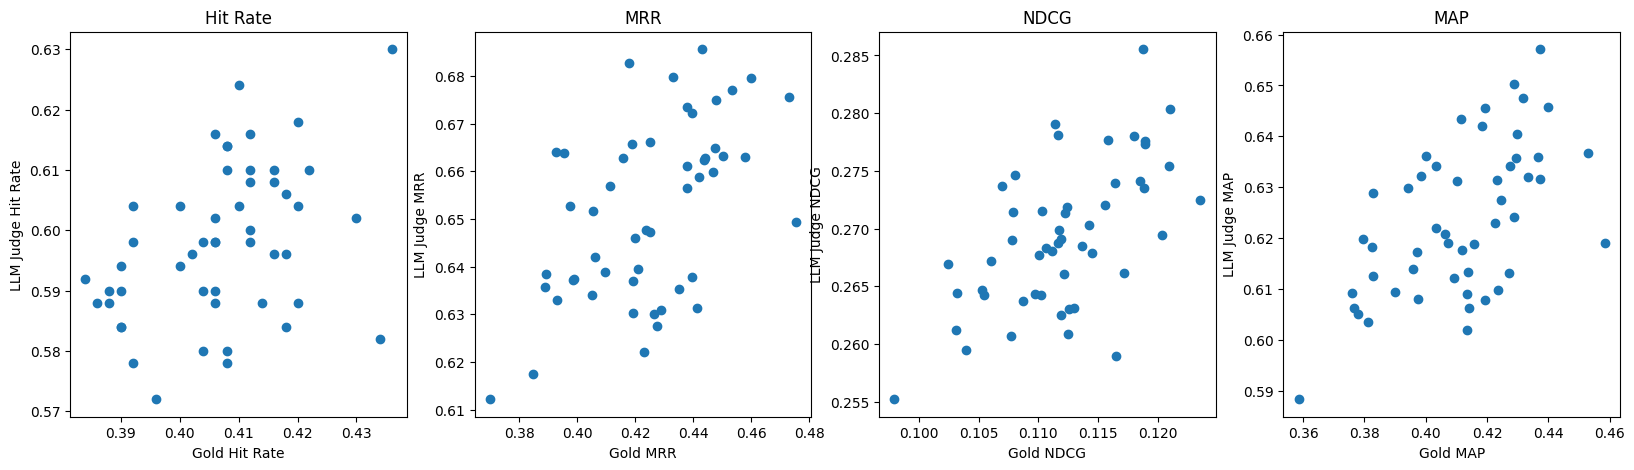

In [34]:

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.scatter(gold_hit_rates, llm_judge_hit_rates)
plt.xlabel("Gold Hit Rate")
plt.ylabel("LLM Judge Hit Rate")
plt.title("Hit Rate")
plt.subplot(1, 4, 2)
plt.scatter(gold_mrrs, llm_judge_mrrs)
plt.xlabel("Gold MRR")
plt.ylabel("LLM Judge MRR")
plt.title("MRR")
plt.subplot(1, 4, 3)
plt.scatter(gold_ndcgs, llm_judge_ndcgs)
plt.xlabel("Gold NDCG")
plt.ylabel("LLM Judge NDCG")
plt.title("NDCG")
plt.subplot(1, 4, 4)
plt.scatter(gold_maps, llm_judge_maps)
plt.xlabel("Gold MAP")
plt.ylabel("LLM Judge MAP")
plt.title("MAP")
plt.show()

In [35]:
print("Binary judge (>0.0)")
pd.DataFrame([
    { "metric": "hit_rate", "gold": np.mean(gold_hit_rates), "llm_judge": np.mean(binary_llm_judge_hit_rates), "correlation": pearsonr(gold_hit_rates, binary_llm_judge_hit_rates).statistic },
    { "metric": "mrr", "gold": np.mean(gold_mrrs), "llm_judge": np.mean(binary_llm_judge_mrrs), "correlation": pearsonr(gold_mrrs, binary_llm_judge_mrrs).statistic },
    { "metric": "ndcg", "gold": np.mean(gold_ndcgs), "llm_judge": np.mean(binary_llm_judge_ndcgs), "correlation": pearsonr(gold_ndcgs, binary_llm_judge_ndcgs).statistic },
    { "metric": "map", "gold": np.mean(gold_maps), "llm_judge": np.mean(binary_llm_judge_maps), "correlation": pearsonr(gold_maps, binary_llm_judge_maps).statistic},
    ])

Binary judge (>0.0)


,metric,gold,llm_judge,correlation
0,hit_rate,0.406920,0.937920,0.425989
1,mrr,0.424885,0.651527,0.538357
2,ndcg,0.112072,0.475037,0.550855
3,map,0.411097,0.623592,0.575534


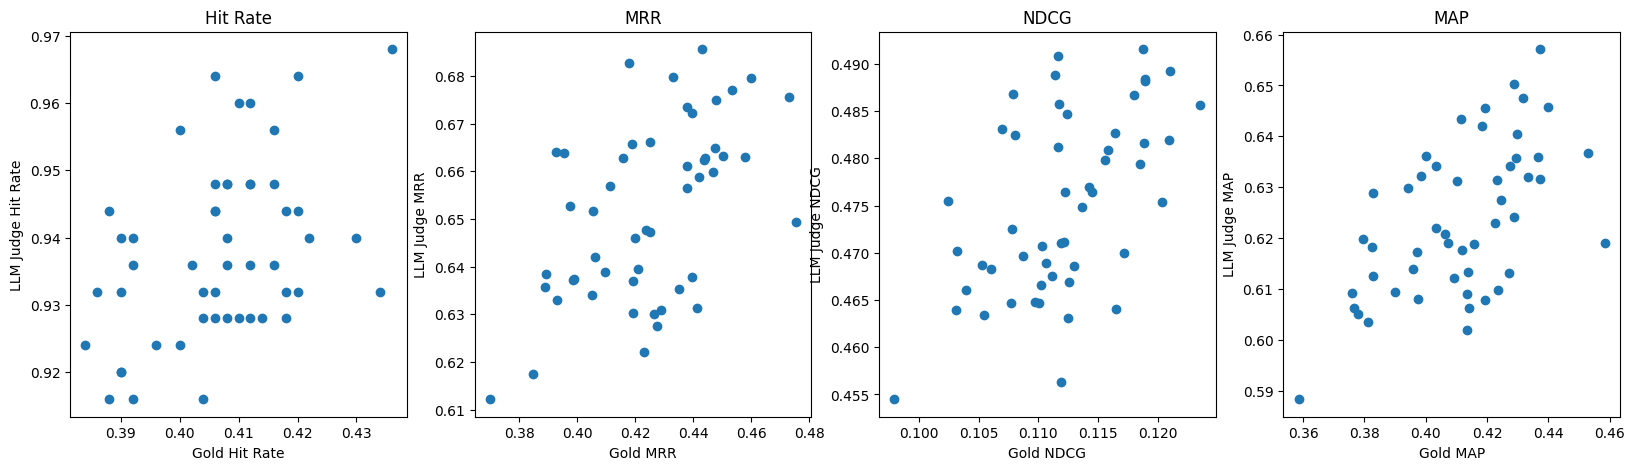

In [36]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.scatter(gold_hit_rates, binary_llm_judge_hit_rates)
plt.xlabel("Gold Hit Rate")
plt.ylabel("LLM Judge Hit Rate")
plt.title("Hit Rate")
plt.subplot(1, 4, 2)
plt.scatter(gold_mrrs, binary_llm_judge_mrrs)
plt.xlabel("Gold MRR")
plt.ylabel("LLM Judge MRR")
plt.title("MRR")
plt.subplot(1, 4, 3)
plt.scatter(gold_ndcgs, binary_llm_judge_ndcgs)
plt.xlabel("Gold NDCG")
plt.ylabel("LLM Judge NDCG")
plt.title("NDCG")
plt.subplot(1, 4, 4)
plt.scatter(gold_maps, binary_llm_judge_maps)
plt.xlabel("Gold MAP")
plt.ylabel("LLM Judge MAP")
plt.title("MAP")
plt.show()